In [0]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import copy

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

imsize = 1024 if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])

def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader("OtherNight.jpg")
content_img = image_loader("swiss.jpg")

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"


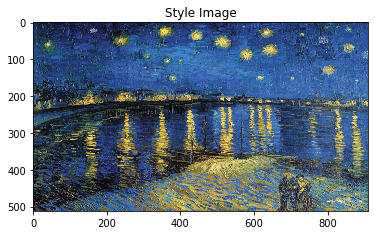

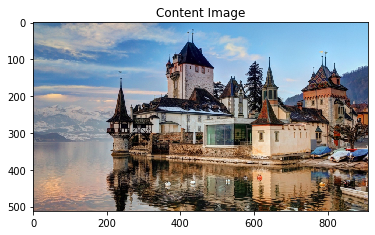

In [77]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [0]:
cnn = cnn = models.vgg19(pretrained=True).features.to(device).eval()



In [0]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [0]:
class ContentLoss(nn.Module):
    def __init__(self, target):
      super(ContentLoss, self).__init__()
      self.target = target.detach()
    def forward(self,inp):
      self.loss = F.mse_loss(inp,self.target)
      return inp

In [0]:
def gram_matrix(x):
  a,b,c,d = x.shape
  x = x.view(a*b,c*d)
  return torch.matmul(x,x.t()) / (a * b * c * d)

In [0]:
class StyleLoss(nn.Module):
  def __init__(self,target):
    super(StyleLoss, self).__init__()
    self.gram = gram_matrix(target)
  def forward(self,inp):
    self.loss = F.mse_loss(gram_matrix(inp),self.gram)
    return inp

In [0]:
def get_model_and_losses(cnn,style,content,mean,std):
  cnn = deepcopy(cnn)
  content_layers = ['conv_4']
  style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
  content_losses = []
  style_losses = []
  i = 0
  model = nn.Sequential(Normalization(mean,std))
  for layer in cnn.children():
    if isinstance(layer,nn.Conv2d):
      i += 1
      name = "conv_{}".format(i)
    elif isinstance(layer, nn.ReLU):
      name = "ReLU_{}".format(i)
      layer = nn.ReLU(inplace=False)
    elif isinstance(layer, nn.MaxPool2d):
      name = "pool_{}".format(i)
    elif isinstance(layer, nn.BatchNorm2d):
      name = "bn_{}".format(i)
    model.add_module(name,layer)
    if name in content_layers:
      target = model(content).detach()
      c_loss = ContentLoss(target)
      model.add_module("ContentLoss_{}".format(i),c_loss)
      content_losses.append(c_loss)
    if name in style_layers:
      target = model(style).detach()
      s_loss = StyleLoss(target)
      model.add_module("StyleLoss_{}".format(i),s_loss)
      style_losses.append(s_loss)

  for i in range(len(model) - 1,-1,-1):
    if isinstance(model[i],StyleLoss) or isinstance(model[i],ContentLoss):
      break
    model = model[:i+1]
  return model, content_losses, style_losses


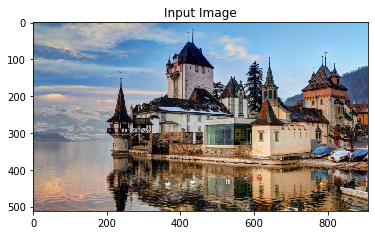

In [109]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

In [0]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
  model, c_losses, s_losses = get_model_and_losses(cnn,style_img,content_img,cnn_normalization_mean,cnn_normalization_std)
  input_img = content_img.clone()

  opt = optim.LBFGS([input_img.requires_grad_()])
  k = [0]
  while k[0] <= num_steps:
    print(k[0])
    def descend():
      input_img.data.clamp_(0, 1)
      opt.zero_grad()
      model(input_img)
      c_score = 0.0
      s_score = 0.0
      for c in c_losses:
        c_score += c.loss
      for s in s_losses:
        s_score += s.loss
      c_score *= content_weight
      s_score *= style_weight
      total_loss = c_score + s_score
      total_loss.backward()
      k[0]+=1
      if k[0] % 10 == 0:
        print("{}/{} Style loss: {}   Content_loss:{}".format(k[0],num_steps,s_score,c_score))
      return c_score + s_score
    opt.step(descend)
  input_img.data.clamp_(0, 1)
  return input_img


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


<class 'list'>
0
10/300 Style loss: 4919.8876953125   Content_loss:27.196413040161133
20/300 Style loss: 722.5825805664062   Content_loss:29.31746482849121
20
30/300 Style loss: 233.6676483154297   Content_loss:28.6624755859375
40/300 Style loss: 161.35455322265625   Content_loss:28.242956161499023
40
50/300 Style loss: 119.46176147460938   Content_loss:27.839021682739258
60/300 Style loss: 92.2525634765625   Content_loss:27.245317459106445
60
70/300 Style loss: 73.03934478759766   Content_loss:26.57058334350586
80/300 Style loss: 58.89480209350586   Content_loss:25.897789001464844
80
90/300 Style loss: 49.22408676147461   Content_loss:25.144716262817383
100/300 Style loss: 62.99569320678711   Content_loss:24.455379486083984
100
110/300 Style loss: 48.18415069580078   Content_loss:23.798725128173828
120/300 Style loss: 25.43208885192871   Content_loss:23.275571823120117
120
130/300 Style loss: 21.00424575805664   Content_loss:22.593177795410156
140/300 Style loss: 17.57402801513672   C

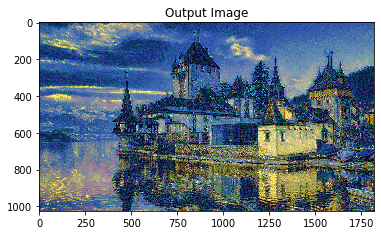

In [145]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img,num_steps=300)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

In [0]:
    image = output.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    image.save("/content/drive/My Drive/test.jpg")